<a href="https://colab.research.google.com/github/malfarisi43/TB1-PWE/blob/main/data_kebijakan_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00


In [3]:
# STEP 1: Import Library

import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [4]:
# STEP 2: Load Data
df = pd.read_excel('Data_Kebijakan_Bapanas.xlsx', sheet_name='Data_Lengkap')

In [5]:
# STEP 3: Labeling Otomatis Berdasarkan Keyword
def label_berita(teks):
    teks = teks.lower()
    if any(kata in teks for kata in ['krisis', 'rawan', 'darurat', 'tinggi', 'ancaman']):
        return 'rentan'
    elif any(kata in teks for kata in ['waspada', 'siaga', 'monitor', 'pantau']):
        return 'waspada'
    elif any(kata in teks for kata in ['aman', 'stabil', 'cukup', 'terkendali']):
        return 'aman'
    else:
        return 'waspada'

df['label'] = df['Judul'].apply(label_berita)

In [6]:
# STEP 4: Preprocessing
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def clean_text(text):
    # lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove extra whitespace
    text = text.strip()
    # remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords]
    # stemming
    text = ' '.join([stemmer.stem(word) for word in tokens])
    return text

df['cleaned'] = df['Judul'].astype(str).apply(clean_text)


In [7]:
# STEP 5: Tokenisasi & Padding
X = df['cleaned'].values
y = df['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_seq_len = max(len(seq) for seq in X_seq)
X_pad = pad_sequences(X_seq, maxlen=max_seq_len, padding='post')

In [8]:
# STEP 6: Label Encoding
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)
y_cat = to_categorical(y_enc)

In [17]:
# STEP 7: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# STEP 8: Build Model Bi-LSTM
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 kelas
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# STEP 9: Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7149 - loss: 0.9360 - val_accuracy: 0.7733 - val_loss: 0.6796
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7917 - loss: 0.6336 - val_accuracy: 0.7733 - val_loss: 0.6583
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7852 - loss: 0.6405 - val_accuracy: 0.7733 - val_loss: 0.6436
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7687 - loss: 0.5768 - val_accuracy: 0.8000 - val_loss: 0.5330
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8232 - loss: 0.3693 - val_accuracy: 0.8533 - val_loss: 0.5012
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8988 - loss: 0.2625 - val_accuracy: 0.8733 - val_loss: 0.4028
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9356 - loss: 0.1622 - val_accuracy: 0.8733 - val_loss: 0.4156
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9660 - loss: 0.0902 - val_accuracy: 0.9200 - val_loss: 0.

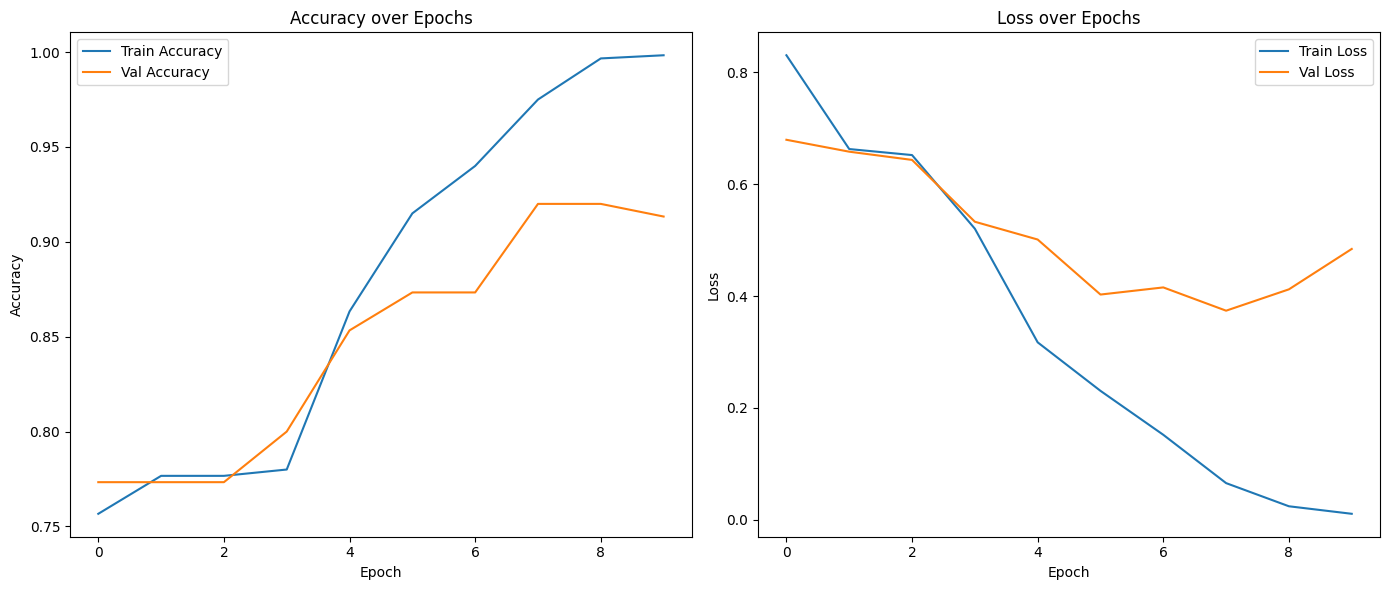

In [18]:
# --- STEP 10: Evaluasi dan Visualisasi ---
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Classification Report:
              precision    recall  f1-score   support

        aman       0.79      0.79      0.79        24
      rentan       0.89      0.80      0.84        10
     waspada       0.94      0.95      0.94       116

    accuracy                           0.91       150
   macro avg       0.87      0.85      0.86       150
weighted avg       0.91      0.91      0.91       150



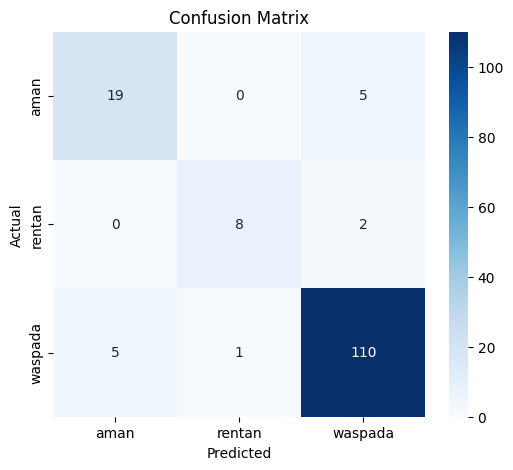

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prediksi pada data uji
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Tampilkan classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [20]:
# --- STEP 11: Prediksi Judul Asli ---
X_all = tokenizer.texts_to_sequences(df['cleaned'])
X_all_pad = pad_sequences(X_all, maxlen=max_seq_len, padding='post')
y_pred_all = model.predict(X_all_pad)
y_pred_labels = np.argmax(y_pred_all, axis=1)
labels_str = label_encoder.inverse_transform(y_pred_labels)

# Tambahkan hasil prediksi ke DataFrame
df['Prediksi_BI_LSTM'] = labels_str


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<ipython-input-21-9275618f226a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Prediksi_BI_LSTM', data=df, order=label_encoder.classes_, palette='Set2')


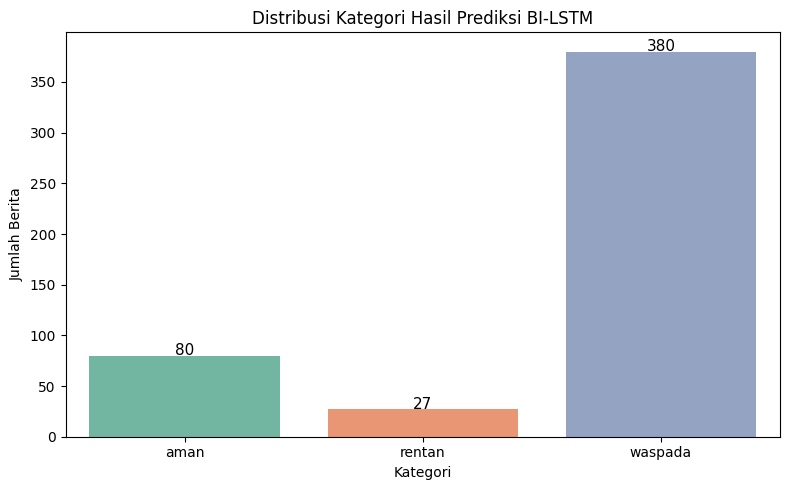

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Prediksi_BI_LSTM', data=df, order=label_encoder.classes_, palette='Set2')
plt.title('Distribusi Kategori Hasil Prediksi BI-LSTM')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Berita')

# Tambahkan angka di atas setiap bar
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5,
            str(count), ha="center", fontsize=11)

plt.tight_layout()
plt.show()


<ipython-input-22-e8d4f4865a37>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Tahun'] = pd.to_datetime(df['Tanggal'], errors='coerce').dt.year


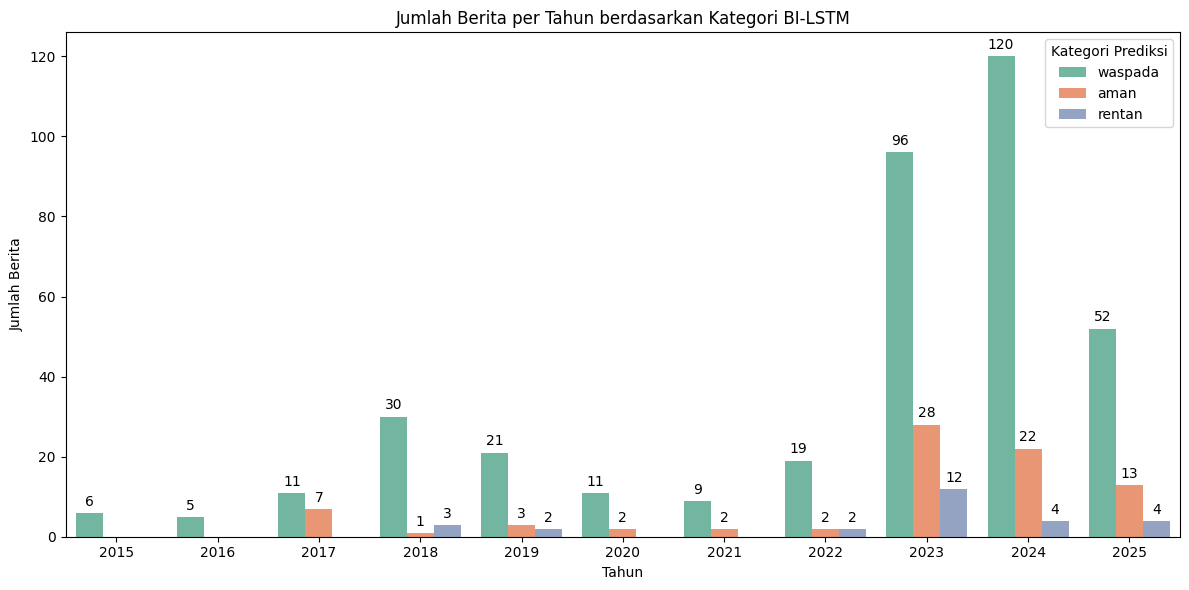

In [22]:
# --- STEP 15: Ekstrak Tahun dari Kolom Tanggal ---
df['Tahun'] = pd.to_datetime(df['Tanggal'], errors='coerce').dt.year
df = df.dropna(subset=['Tahun'])

# --- STEP 16: Grouping Data ---
grouped = df.groupby(['Tahun', 'Prediksi_BI_LSTM']).size().reset_index(name='Jumlah')

# --- STEP 17: Bar Chart dengan Angka di Atasnya ---
plt.figure(figsize=(12,6))
ax = sns.barplot(data=grouped, x='Tahun', y='Jumlah', hue='Prediksi_BI_LSTM', palette='Set2')

# Tambahkan angka di atas tiap bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Jumlah Berita per Tahun berdasarkan Kategori BI-LSTM')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Berita')
plt.legend(title='Kategori Prediksi')
plt.tight_layout()
plt.show()


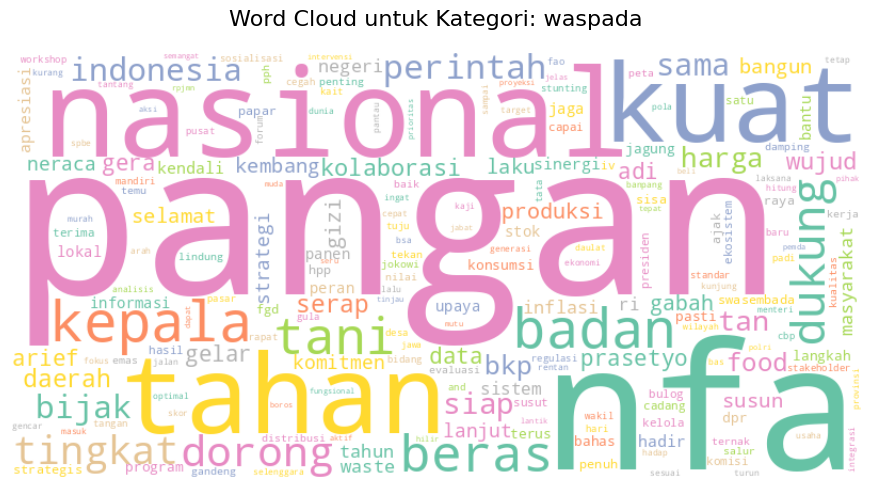


📌 Top 15 kata terbanyak untuk kategori: waspada
1. pangan               ➜ 303 kemunculan
2. nfa                  ➜ 198 kemunculan
3. nasional             ➜ 77 kemunculan
4. tahan                ➜ 59 kemunculan
5. kuat                 ➜ 58 kemunculan
6. kepala               ➜ 55 kemunculan
7. badan                ➜ 51 kemunculan
8. tani                 ➜ 45 kemunculan
9. beras                ➜ 45 kemunculan
10. dukung               ➜ 37 kemunculan
11. dorong               ➜ 35 kemunculan
12. tingkat              ➜ 34 kemunculan
13. perintah             ➜ 32 kemunculan
14. indonesia            ➜ 29 kemunculan
15. bijak                ➜ 29 kemunculan

--------------------------------------------------



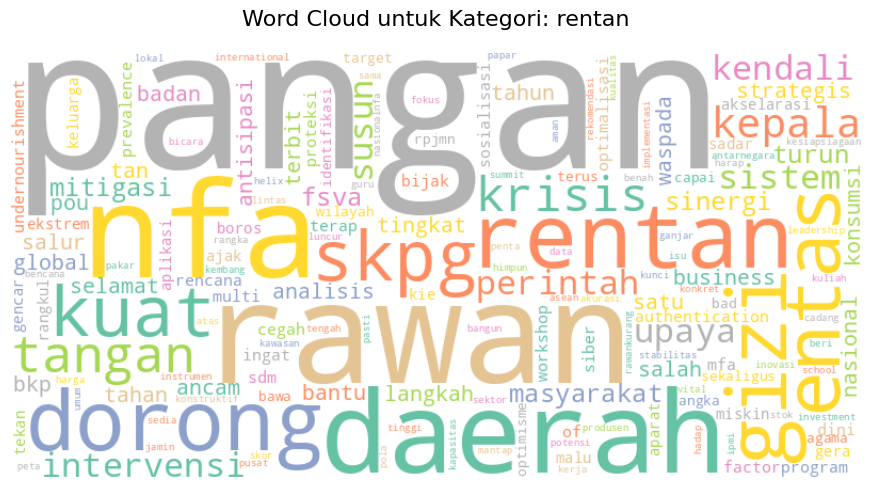


📌 Top 15 kata terbanyak untuk kategori: rentan
1. pangan               ➜ 45 kemunculan
2. rawan                ➜ 20 kemunculan
3. nfa                  ➜ 17 kemunculan
4. daerah               ➜ 12 kemunculan
5. rentan               ➜ 7 kemunculan
6. dorong               ➜ 6 kemunculan
7. gizi                 ➜ 6 kemunculan
8. entas                ➜ 5 kemunculan
9. kuat                 ➜ 4 kemunculan
10. skpg                 ➜ 4 kemunculan
11. tangan               ➜ 4 kemunculan
12. krisis               ➜ 4 kemunculan
13. kepala               ➜ 4 kemunculan
14. perintah             ➜ 3 kemunculan
15. susun                ➜ 3 kemunculan

--------------------------------------------------



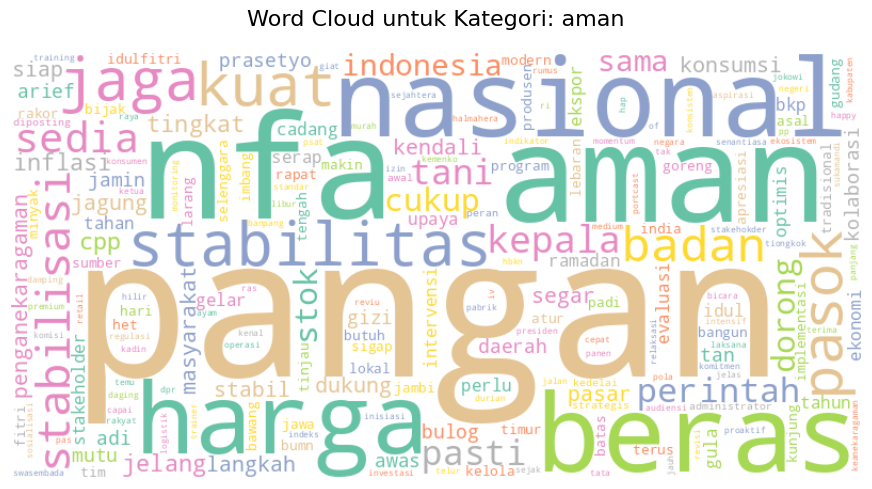


📌 Top 15 kata terbanyak untuk kategori: aman
1. pangan               ➜ 84 kemunculan
2. nfa                  ➜ 38 kemunculan
3. aman                 ➜ 35 kemunculan
4. nasional             ➜ 20 kemunculan
5. beras                ➜ 20 kemunculan
6. harga                ➜ 20 kemunculan
7. stabilitas           ➜ 19 kemunculan
8. jaga                 ➜ 18 kemunculan
9. kuat                 ➜ 18 kemunculan
10. pasok                ➜ 17 kemunculan
11. badan                ➜ 12 kemunculan
12. stabilisasi          ➜ 11 kemunculan
13. sedia                ➜ 9 kemunculan
14. kepala               ➜ 9 kemunculan
15. tani                 ➜ 8 kemunculan

--------------------------------------------------



In [23]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# --- Fungsi Word Cloud + Frekuensi Kata ---
def tampilkan_wordcloud_dan_kata_terbanyak(df_sub, label_kategori, top_n=10):
    # Gabungkan semua teks
    text = ' '.join(df_sub['cleaned'])
    words = text.split()

    # Hitung frekuensi kata
    word_freq = Counter(words)

    # Buat WordCloud berdasarkan frekuensi
    wc = WordCloud(width=800, height=400, background_color='white',
                   colormap='Set2').generate_from_frequencies(word_freq)

    # Tampilkan Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Kategori: {label_kategori}', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Tampilkan kata-kata paling sering
    print(f'\n📌 Top {top_n} kata terbanyak untuk kategori: {label_kategori}')
    for i, (kata, frek) in enumerate(word_freq.most_common(top_n), 1):
        print(f'{i}. {kata:<20} ➜ {frek} kemunculan')
    print('\n' + '-'*50 + '\n')

# --- Iterasi untuk Semua Kategori ---
kategori_list = df['Prediksi_BI_LSTM'].unique()

for kategori in kategori_list:
    df_kategori = df[df['Prediksi_BI_LSTM'] == kategori]
    tampilkan_wordcloud_dan_kata_terbanyak(df_kategori, kategori, top_n=15)  # Bisa ubah top_n sesuai kebutuhan
